In [240]:
from collections import Counter
import random

import matplotlib.pyplot as plt
import numpy as np

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import normalizers
from tokenizers.normalizers import NFD, StripAccents, Lowercase
from tokenizers.pre_tokenizers import Whitespace

from datasets import load_dataset

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

In [241]:
dataset = load_dataset("dair-ai/emotion")

In [242]:
train_data = dataset['train']
test_data = dataset['test']
validation_data = dataset['validation']
label_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [243]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.enable_padding()
trainer = BpeTrainer(special_tokens=[
	"[UNK]" , "[PAD]"
])

normalizer = normalizers.Sequence([NFD(), StripAccents(), Lowercase()])
tokenizer.normalizer = normalizer

pre_tokenizer = Whitespace()
tokenizer.pre_tokenizer = pre_tokenizer

tokenizer.train_from_iterator(train_data['text'], trainer)

padding_idx = tokenizer.token_to_id("[PAD]")

In [244]:
def tokenization(example):
	output = tokenizer.encode(example['text'])
	return {
		"ids": output.ids,
		"type_ids": output.type_ids,
		"attention_mask": output.attention_mask
	}

train_data_tokenized = train_data.map(tokenization)
train_data_tokenized.set_format(type="torch", columns=["ids", "type_ids", "attention_mask", "label"])

validation_data_tokenized = validation_data.map(tokenization)
validation_data_tokenized.set_format(type="torch", columns=["ids", "type_ids", "attention_mask", "label"])

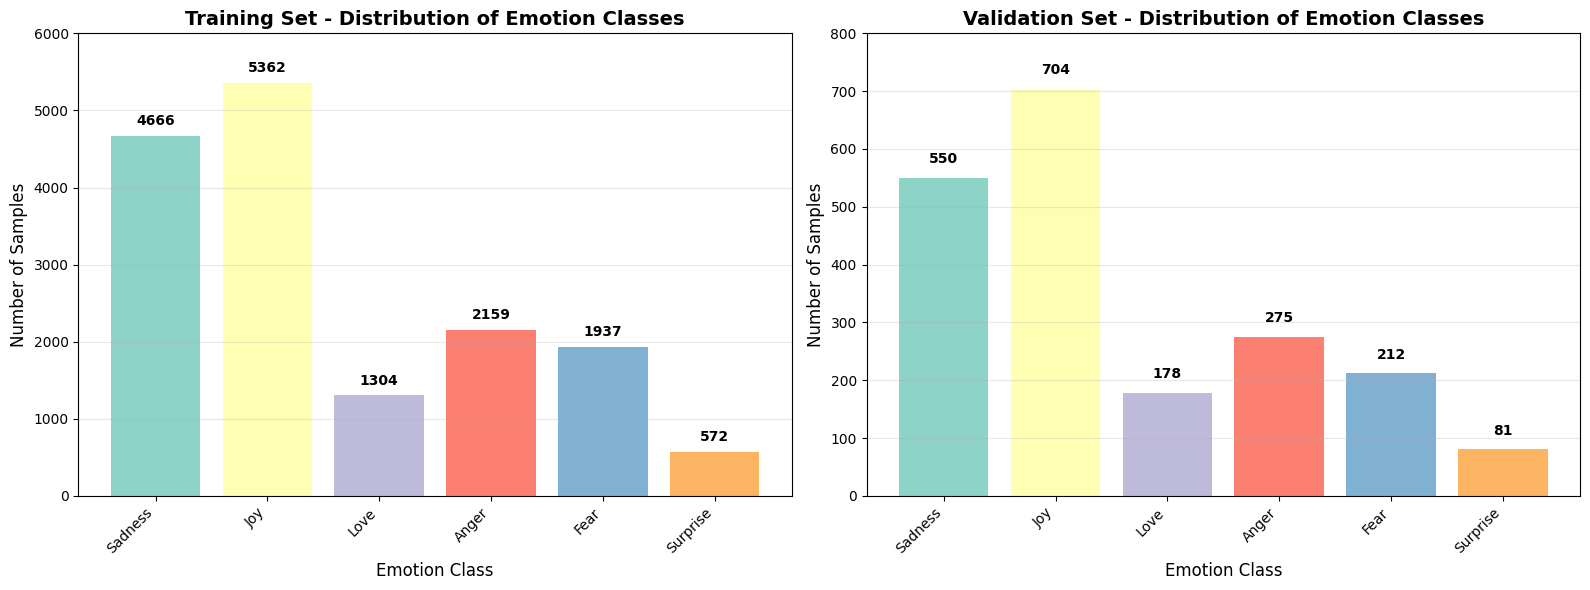

In [245]:
train_label_counts = Counter(train_data['label'])
validation_label_counts = Counter(validation_data['label'])
test_label_counts = Counter(test_data['label'])

def plot_class_distribution_combined(train_counts, val_counts, label_names):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    classes = sorted(train_counts.keys())
    train_data = [train_counts[i] for i in classes]
    val_data = [val_counts[i] for i in classes]
    colors = plt.cm.Set3(range(len(classes)))
    
    axes[0].bar(classes, train_data, color=colors)
    axes[0].set_xlabel('Emotion Class', fontsize=12)
    axes[0].set_ylabel('Number of Samples', fontsize=12)
    axes[0].set_title('Training Set - Distribution of Emotion Classes', fontsize=14, fontweight='bold')
    axes[0].set_xticks(classes)
    axes[0].set_xticklabels([label_names[i].capitalize() for i in classes], rotation=45, ha='right')
    axes[0].set_ylim(0, 6000)
    axes[0].grid(axis='y', alpha=0.3)
    
    for i, (c, count) in enumerate(zip(classes, train_data)):
        axes[0].text(c, count + 100, str(count), ha='center', va='bottom', fontweight='bold')
    
    axes[1].bar(classes, val_data, color=colors)
    axes[1].set_xlabel('Emotion Class', fontsize=12)
    axes[1].set_ylabel('Number of Samples', fontsize=12)
    axes[1].set_title('Validation Set - Distribution of Emotion Classes', fontsize=14, fontweight='bold')
    axes[1].set_xticks(classes)
    axes[1].set_xticklabels([label_names[i].capitalize() for i in classes], rotation=45, ha='right')
    axes[1].set_ylim(0, 800)
    axes[1].grid(axis='y', alpha=0.3)
    
    for i, (c, count) in enumerate(zip(classes, val_data)):
        axes[1].text(c, count + 20, str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('class_distribution_combined.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_class_distribution_combined(train_label_counts, validation_label_counts, label_names)

In [246]:
class RNN(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size
        
        self.embedding = nn.Embedding(self.input_size, self.emb_size, padding_idx=padding_idx)
        self.dropout_emb = nn.Dropout(0.2)
        self.rnn = nn.RNN(self.emb_size, hidden_size, num_layers=1, batch_first=True)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X, lengths):
        emb = self.dropout_emb(self.embedding(X))
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.rnn(packed)
        
        hidden = self.dropout(h_n[0])
        logits = self.h2o(hidden)
        return logits

In [247]:
class GRU(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size
        
        self.embedding = nn.Embedding(self.input_size, self.emb_size, padding_idx=padding_idx)
        self.dropout_emb = nn.Dropout(0.2)
        self.rnn = nn.GRU(self.emb_size, hidden_size, num_layers=1, batch_first=True)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X, lengths):
        emb = self.dropout_emb(self.embedding(X))
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.rnn(packed)

        hidden = self.dropout(h_n[0])
        logits = self.h2o(hidden)
        return logits

In [248]:
class LSTM(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb_size = emb_size
        
        self.embedding = nn.Embedding(self.input_size, self.emb_size, padding_idx=padding_idx)
        self.dropout_emb = nn.Dropout(0.2)
        self.rnn = nn.LSTM(self.emb_size, hidden_size, num_layers=1, batch_first=True)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, X, lengths):
        emb = self.dropout_emb(self.embedding(X))
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, c_n) = self.rnn(packed)
        if self.rnn.bidirectional:
            hidden = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            hidden = h_n[-1]
        
        hidden = self.dropout(hidden)
        logits = self.h2o(hidden)
        return logits

In [249]:
input_size = tokenizer.get_vocab_size()
emb_size = 256
hidden_size = 128
output_size = len(set(train_data['label']))

model = LSTM(input_size, emb_size, hidden_size, output_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

label_counts = Counter(train_data['label'])
total = sum(label_counts.values())
class_weights = torch.tensor([total / (len(label_counts) * label_counts[i]) for i in range(len(label_counts))])
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [250]:
def collate_fn(batch):
	ids = [torch.as_tensor(x["ids"], dtype=torch.long) for x in batch]
	attn = [torch.as_tensor(x["attention_mask"], dtype=torch.long) for x in batch]
	labels = torch.as_tensor([x["label"] for x in batch], dtype=torch.long)
	
	ids = torch.nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=padding_idx)
	attn = torch.nn.utils.rnn.pad_sequence(attn, batch_first=True, padding_value=0)

	lengths = attn.sum(dim=1)
	return {
		"input_ids": ids,
		"attention_mask": attn,
		"labels": labels,
		"lengths": lengths,
	}

In [251]:
train_data_loader = DataLoader(train_data_tokenized, batch_size=32, collate_fn=collate_fn, shuffle=True)
validation_data_loader = DataLoader(validation_data_tokenized, batch_size=32, collate_fn=collate_fn, shuffle=False)

In [252]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)

    for batch, data in enumerate(dataloader):
        X = data['input_ids']
        y = data['labels']
        lengths = data['lengths']
        
        preds = model(X, lengths)
        loss = loss_fn(preds, y)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    avg_loss = total_loss / num_batches
    return avg_loss

def eval_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    total_correct, total_examples = 0, 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for data in dataloader:
            X = data['input_ids']
            y = data['labels']
            lengths = data['lengths']
            
            preds = model(X, lengths)
            pred_labels = torch.argmax(preds, dim=1)
            loss = loss_fn(preds, y)
            total_loss += loss.item()

            total_examples += X.size()[0]
            total_correct += (pred_labels == y).sum().item()
    
    avg_loss = total_loss / num_batches
    accuracy = total_correct / total_examples * 100
    return avg_loss, accuracy


In [253]:
train_losses = []
validation_losses = []
validation_accuracies = []
for epoch in range(5):
    train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
    validation_loss, validation_accuracy = eval_loop(validation_data_loader, model, loss_fn)
    print(f"Epoch: {epoch + 1}, Training Loss:{train_loss:.4f}, Validation Loss:{validation_loss:.4f}, Validation Accuracy:{validation_accuracy:.4f}")
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

Epoch: 1, Training Loss:1.4761, Validation Loss:0.6976, Validation Accuracy:76.1500
Epoch: 2, Training Loss:0.5115, Validation Loss:0.4235, Validation Accuracy:87.7000
Epoch: 3, Training Loss:0.2480, Validation Loss:0.3691, Validation Accuracy:89.6000
Epoch: 4, Training Loss:0.1567, Validation Loss:0.3615, Validation Accuracy:90.2500
Epoch: 5, Training Loss:0.1023, Validation Loss:0.3638, Validation Accuracy:92.5500


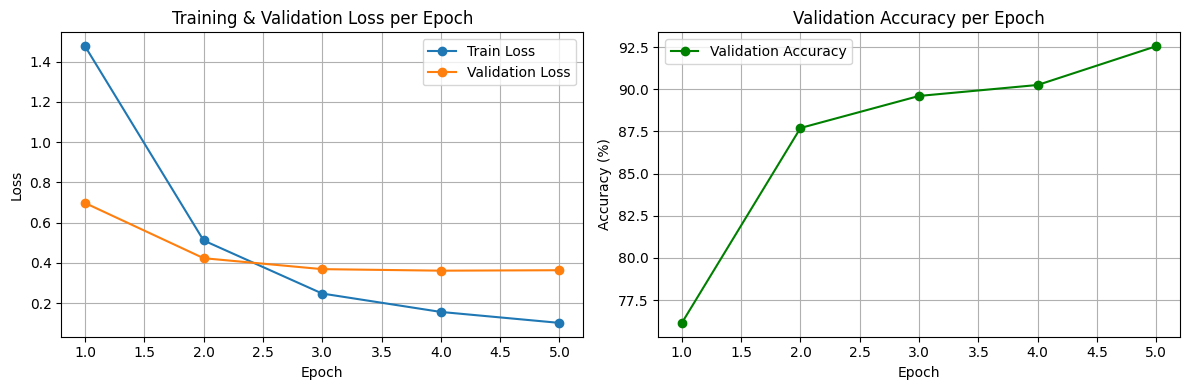

In [254]:
epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs, train_losses, marker='o', label='Train Loss')
axes[0].plot(epochs, validation_losses, marker='o', label='Validation Loss')
axes[0].set_title("Training & Validation Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(epochs, validation_accuracies, marker='o', color='green', label='Validation Accuracy')
axes[1].set_title("Validation Accuracy per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [255]:
def predict(text, model, tokenizer):
    model.eval()
    
    encoding = tokenizer.encode(text)
    ids = torch.tensor([encoding.ids], dtype=torch.long)
    lengths = torch.tensor([len(encoding.ids)], dtype=torch.long)

    with torch.no_grad():
        logits = model(ids, lengths)
        probs = torch.softmax(logits, dim=1).squeeze(0)
        pred_label = torch.argmax(probs).item()

    print(f"\nInput text: {text}")
    print(f"Predicted Emotion: {label_names[pred_label].upper()} (class {pred_label})")

In [257]:
for _ in range(5):
    sample = random.choice(test_data)
    text, true_label = sample["text"], sample["label"]
    print(f"\nActual label: {label_names[true_label].upper()} (class {true_label})")
    predict(text, model, tokenizer)


Actual label: JOY (class 1)

Input text: im sure ill feel more playful soon but i just cant right now
Predicted Emotion: JOY (class 1)

Actual label: JOY (class 1)

Input text: i feel happy about the outcome of this long election and im glad its over
Predicted Emotion: JOY (class 1)

Actual label: SADNESS (class 0)

Input text: i feel like there is no way out being humiliated by asa a guy i was obssessed about who played an embarrassing joke on me getting caught by tabbys wife tabby is a lover i once had who was married and i blindly fell in love with him
Predicted Emotion: SADNESS (class 0)

Actual label: SADNESS (class 0)

Input text: i first started using this i did not like it because i felt like it made my hair feel very dirty even though i had just washed my hair
Predicted Emotion: SADNESS (class 0)

Actual label: SADNESS (class 0)

Input text: i am going through trials or just feeling troubled about something i love to put on worship music while i am driving and really think ab